In [3]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [4]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int', 'preco_pon', 'qnt_soma']#, 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 350 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
l = n_variaveis-1
tam_janela = n_variaveis*janela
n_entradas = n_variaveis * janela + 2 #ncont, valor e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
lim_cont = 5
n_saidas = 2*lim_cont+1   #numero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0

versao_arquivo = 2

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1. #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [5]:
####################### LEITURA DOS DADOS #######################################################
dias = 250

caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
inputs_nao_norm = arquivo[index_arquivo]
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
hr = []
h = 0
n_steps = 106 #especifico pra 5min
for i in range( 0, len(dt) ):    
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
        h = 0
    hr.append(h)
    h += 1
step_max = np.amax(hr)
batch = step_max + 1
print(inputs)
#normalizacao dos dados
hr = hr/step_max
inputs['hr_int'] = hr
pmean = np.mean( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor minimo do preco  #step = 106
pstd = np.std( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor maximo do preco
for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imean = np.mean( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor maximo
    istd = np.std( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor minimo
       
    inputs.loc[:, inputs.columns[i]] = inputs.loc[:, inputs.columns[i]] - imean 

valor0 = np.amin(inputs['preco']) - 500
mini_batch_size = int(dias*batch*0.1)

        preco    hr_int  preco_pon  qnt_soma
0      3907.5  32700000    3907.50       1.0
1      3900.0  33000000    3901.26   20309.0
2      3898.0  33300000    3901.42   17614.0
3      3898.0  33600000    3895.37   14283.0
4      3899.5  33900000    3897.78    6638.0
...       ...       ...        ...       ...
30099  4074.0  63000000    4074.69    9221.0
30100  4071.5  63300000    4071.88    5389.0
30101  4071.0  63600000    4070.23    5930.0
30102  4069.0  63900000    4071.37    5387.0
30103  4068.5  64200000    4069.33    4407.0

[30104 rows x 4 columns]


C:\Users\core\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\core\Anaconda3\lib\site-packages\pandas\core\indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [6]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import backend as K            #importa backend para clear_session()


##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = 5
        self.action_size = action_size
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria_dia()
        self.limpa_memoria_epoca()
        self.gamma = 0.98     # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-5
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []
        self.janela_precos = []
        self.prox_janela_precos = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        """
        
        model.add(Dense(512, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(256, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(256, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(196, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)        
        model.add(Dense(128, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(64, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(32, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        
        #model.add(Dense(128, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        #model.add(Dense(x*3, activation='relu')) #camada escondida
        #model.add(Dense(x*2, activation='relu')) #camada escondida
        #model.add(Dense(x, activation='relu')) #camada escondida
        #model.add(Dense(64, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='linear')) #camada de saida
        model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        #sgd = optimizers.SGD(lr=self.learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        #model.compile(loss='mse', optimizer=sgd)
        return model

    def limpa_memoria_dia(self):
        self.janela_precos = np.zeros(n_variaveis*janela)
        self.prox_janela_precos = np.zeros(n_variaveis*janela)
        self.state = []
        self.next_state = []
    
    def limpa_memoria_epoca(self):
        self.memory = []
        
    def toma_acao(self):
        if np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria     
        act_values = self.model.predict(self.state) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action
    
    def treina_modelo(self, batch_size=mini_batch_size):
        minibatch = random.sample(self.memory, batch_size) if dias>5 else self.memory
        
        x = []
        y = []
        for acao, reward, estado, prox_estado, done in minibatch:        
            
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(prox_estado)[0])) #pega valor que quer chegar
            
            target_f = self.model.predict(estado) 
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x.append(estado[0])
            y.append(target_f[0])
            
        self.model.fit(np.asarray(x), np.asarray(y), epochs=1, verbose=0) #treina modelo
        
    def tira_ultima_janela(self):
        if self.janela_precos.shape[0] > self.janela * self.n_variaveis:
            self.janela_precos = self.janela_precos[self.n_variaveis:] #tira os ultimos precos
    
    def remember(self, acao, reward, done):
        self.memory.append((acao, reward, self.state, self.next_state, done))
    
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
                
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               3072      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 196)               50372     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               25216     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [53]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont = acao #posicao atual = acao
    reward = 0.
    posicao = 0.
    dp = 0.

    
    #variaveis para tratamento do sinal de ncont, ncont_anterior e da acao
    acao = ncont - ncont_anterior  #ajuda a manter as condições anteriores
    var1 = ncont*ncont_anterior
    var2 = ncont*acao

    if acao != 0:
        #realizacao de lucros e custos
        if ((var2>0) and (var1>=0)):
            #aumento da posicao
            reward = -custo*abs(acao)    #reward = -custo*acao se houve operacao (aumento da posicao)
            #aumento da posicao = preco medio:
            valor = (ncont_anterior*valor + acao*preco)/ncont  
            
        else:
            valor_cheio = valor * pstd + pmean  #valores nao normalizados
            preco_cheio = preco * pstd + pmean
            if (var1)>= 0:
                #diminuicao da posicao
                reward = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
                #valor medio nao muda na diminuicao, somente se ncont==0:
                if ncont==0: valor=-10
                    
            else:
                #troca de posicao
                reward = (-ncont_anterior)*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve troca da posicao
                #preco medio da posicao = preco da troca de posicao
                valor = preco
    
    #definindo o lucro potencial da carteira(posicao)
    if valor!=-10:
        valor_cheio = valor * pstd + pmean  #valor posicionado atual      
        dp = (preco * pstd + pmean) - valor_cheio #variacao do preco atual e do preco de compra/venda
        posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (POTENCIAL)
        
    return ncont, valor, posicao, reward

def teste(preco, ncont, acao, valor, custo=0):   

    if acao == 0: #zerado
        if ncont>0:  #zerando
            reward = ncont*(preco-valor) -custo*abs(ncont)
        elif ncont<0: #zerando
            reward = ncont*(preco-valor) -custo*abs(ncont)
        else:         
            reward = 0
        valor = valor0
    elif acao>0:  #comprado
        if ncont>0:
            if acao>ncont: #aumento da posicao
                reward = -custo*(acao-ncont)
                valor = (valor*ncont+(acao-ncont)*preco)/(acao)  #calculo preco medio
            elif acao<ncont:  #diminuicao da posicao
                reward = (ncont-acao)*(preco-valor) -custo*(ncont-acao)
                valor = valor #preco medio se mantem
            else:
                reward = 0
        elif ncont<0:   #trocando a mao
            reward = abs(ncont)*(valor-preco) -custo*(acao+abs(ncont))
            valor = preco
        else:          #saiu do zero
            reward = -custo*abs(acao)
            valor = preco
    else:       #vendido
        if ncont>0:#trocando a mao
            reward = ncont*(preco-valor) -custo*(ncont+abs(acao))
            valor = preco
        elif ncont<0:
            if abs(acao)<abs(ncont): #diminuicao da posicao
                reward = (abs(ncont)-abs(acao))*(valor-preco) -custo*(abs(ncont)-abs(acao))
                valor = valor #preco medio se mantem
            elif abs(acao)>abs(ncont): #aumento da posicao
                reward = -custo*(abs(acao)-abs(ncont))
                valor = (valor*abs(ncont)+(abs(acao)-abs(ncont))*preco)/(abs(acao))  #calculo preco medio
            else: #preco medio se mantem
                reward = 0
        else:  #saiu do zero
            reward = -custo*abs(acao)
            valor = preco
                
    #reward = ncont*acao*preco
    ncont = acao
    posicao = ncont*(preco-valor) -custo*abs(ncont) if ncont!=0 else 0.
    return ncont, reward, valor, posicao

def obter_acao():
    decisao = modelo.toma_acao() #calcula a saida da rede neural
    return (decisao - lim_cont)

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = valor0 #cria variavel para preo medio
    reward = 0. #cria variavel para recompensa
    indice = 0
    lucro = 0.
    posicao = 0. #cria variavel de posicao 
    erro = []
    modelo.limpa_memoria_dia() #limpa o vetor de memoria
    done = False
    posicao_max = 1e4
    shp = modelo.janela_precos.shape
    
    for step in range( steps[dia], steps[dia+1] ):  #roda os dados
        
        modelo.state = np.reshape([ncont, indice, precos['preco'][step], valor, precos['preco_pon'][step]], (1,modelo.state_size))
        
        acao = obter_acao()
        ncont, reward, valor, posicao = teste(precos['preco'][step], ncont, acao, valor)
        
        #pos acao
        lucro += reward    #LUCRO ACUMULADO
        
        #v=valor*pstd+pmean if valor!=-100 else 0
        #p=precos['preco'][step]+pmean
        #print("acao={0}; ncont={1}; reward={2} valor={3} preco={4}".format(acao, ncont, reward, valor, precos['preco'][step]))   

        if step == (steps[dia+1] - 1): #se ultimo step do dia
            done = True     
        
        modelo.next_state = np.reshape([ncont, indice+1, precos['preco'][step+1], valor, precos['preco_pon'][step+1]], (1,modelo.state_size))
        modelo.remember(acao, posicao, done)  #salva step na memoria - reward = lucro instantaneo que a ação gerou
        indice += 1
        
    #fim do dia
    lucro +=posicao
    
    #print("ncont zerados={0}; posicao={1}".format(ncont, posicao))
    if lucro > melhor_reward:
        melhor_reward = lucro
    return lucro #retorna o valor do reward

dias_pos = 0
dias_neg = 0
r_dias = []

def rodar_dias(precos, custo, dia_inicial, n_dias):   
    global dias_pos
    global dias_neg
    global r_dias
    r_dias = []
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    
    for dia in range( dia_inicial, dia_inicial+n_dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        r_dias.append(reward)
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards

indic = 0

def train_teste(batch_size=10):
        
        minibatch = modelo.memory
        
        x = []
        y = []
        for acao, reward, estado, prox_estado, done in minibatch:        
            target = reward
            if not done:
                target = (reward + modelo.gamma * np.amax(modelo.model.predict(prox_estado)[0])) #pega valor que quer chegar
            
            target_f = modelo.model.predict(estado)
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x.append(estado[0])
            y.append(target_f[0])
        
        modelo.model.fit(np.asarray(x), np.asarray(y), epochs=1, verbose=0) #treina modelo

W1116 18:08:20.767307  2908 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1116 18:08:39.220362  2908 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W1116 18:08:39.258364  2908 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:438: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



resultado da epoca 0 = 1608.50 Epsilon = 1.000
resultado da epoca 1 = 1508.00 Epsilon = 0.997
resultado da epoca 2 = -53.00 Epsilon = 0.994
resultado da epoca 3 = 1311.00 Epsilon = 0.992
resultado da epoca 4 = -619.00 Epsilon = 0.989
resultado da epoca 5 = 848.00 Epsilon = 0.986
resultado da epoca 6 = 1715.00 Epsilon = 0.983
resultado da epoca 7 = 453.00 Epsilon = 0.980
resultado da epoca 8 = -1593.50 Epsilon = 0.977
resultado da epoca 9 = 1229.50 Epsilon = 0.975
resultado da epoca 10 = -1168.50 Epsilon = 0.972
resultado da epoca 11 = 1181.50 Epsilon = 0.969
resultado da epoca 12 = -973.50 Epsilon = 0.966
resultado da epoca 13 = -1372.00 Epsilon = 0.963
resultado da epoca 14 = 1301.50 Epsilon = 0.960
resultado da epoca 15 = -532.50 Epsilon = 0.958
resultado da epoca 16 = 670.00 Epsilon = 0.955
resultado da epoca 17 = 2559.00 Epsilon = 0.952
resultado da epoca 18 = -3416.50 Epsilon = 0.949
resultado da epoca 19 = 1786.00 Epsilon = 0.946
resultado da epoca 20 = -425.00 Epsilon = 0.943
re

resultado da epoca 170 = 1432.00 Epsilon = 0.519
resultado da epoca 171 = -179.00 Epsilon = 0.516
resultado da epoca 172 = -2139.00 Epsilon = 0.513
resultado da epoca 173 = 1480.00 Epsilon = 0.511
resultado da epoca 174 = 1500.00 Epsilon = 0.508
resultado da epoca 175 = -2492.50 Epsilon = 0.505
resultado da epoca 176 = -2077.00 Epsilon = 0.502
resultado da epoca 177 = 1011.00 Epsilon = 0.499
resultado da epoca 178 = -971.00 Epsilon = 0.497
resultado da epoca 179 = -92.50 Epsilon = 0.494
resultado da epoca 180 = 1732.00 Epsilon = 0.491
resultado da epoca 181 = 2552.50 Epsilon = 0.488
resultado da epoca 182 = 1981.50 Epsilon = 0.485
resultado da epoca 183 = 1275.00 Epsilon = 0.482
resultado da epoca 184 = 2250.00 Epsilon = 0.480
resultado da epoca 185 = -3206.00 Epsilon = 0.477
resultado da epoca 186 = 363.50 Epsilon = 0.474
resultado da epoca 187 = 227.00 Epsilon = 0.471
resultado da epoca 188 = 3459.00 Epsilon = 0.468
resultado da epoca 189 = 1881.50 Epsilon = 0.465
resultado da epoca 

resultado da epoca 338 = 2773.00 Epsilon = 0.044
resultado da epoca 339 = 1324.50 Epsilon = 0.041
resultado da epoca 340 = 2787.50 Epsilon = 0.038
resultado da epoca 341 = 2288.00 Epsilon = 0.035
resultado da epoca 342 = 3220.00 Epsilon = 0.033
resultado da epoca 343 = 2197.50 Epsilon = 0.030
resultado da epoca 344 = 3375.50 Epsilon = 0.027
resultado da epoca 345 = 3706.00 Epsilon = 0.024
resultado da epoca 346 = 1078.50 Epsilon = 0.021
resultado da epoca 347 = 3082.50 Epsilon = 0.018
resultado da epoca 348 = 4535.50 Epsilon = 0.016
resultado da epoca 349 = 2505.50 Epsilon = 0.013
Melhor resultado diario: 802.00


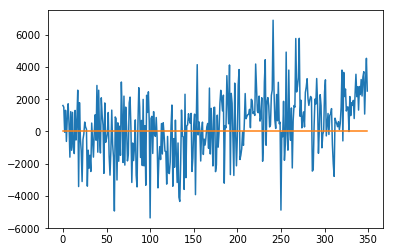

In [6]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    modelo.epsilon = 1.
    melhor_reward = 0
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
            
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas): #rodar uma quantidade de epocas
            modelo.limpa_memoria_epoca()
            sum_rewards = rodar_dias(inputs, custo, 0, dias) #adiciona o resultado da epoca na somatoria
            train_teste() #roda o modelo com toda a memoria da epoca
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f} Epsilon = {2:0.3f}".format(epoca, sum_rewards, modelo.epsilon))
            #print(dias_pos)
            #print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos_5.h5')
            dias_pos = 0
            dias_neg = 0            
            if modelo.epsilon <= epsilon_min:
                modelo.epsilon = epsilon_min
            else:
                modelo.epsilon -= epsilon_decay
    finally:
        #print(dias_pos)
        #print(dias_neg)
        modelo.salva_pesos('./pesos_5.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
            
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca

In [14]:
modelo.carrega_pesos('./pesos_melhor.h5')
modelo.epsilon = 0
print(rodar_dias(inputs, custo, 0, dias))

W1119 00:47:38.764343 13960 deprecation_wrapper.py:119] From C:\Users\core\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



11760.0


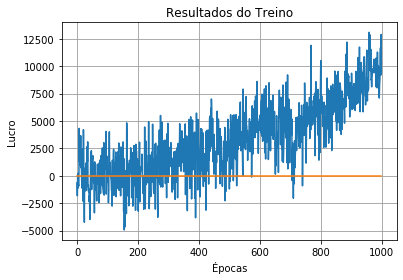

In [49]:
path = ('./treino_14-c.csv')
arq = pd.read_csv(path) #le arquivo
rew = arq['reward']
plt.plot(range(0,len(rew)), rew, range(0,len(rew)), np.zeros(len(rew)))
plt.grid(b=True, which='major', color='#999999', linestyle='-')
plt.title("Resultados do Treino", fontdict=None, loc='center', pad=None)
plt.xlabel('Épocas')
plt.ylabel('Lucro')
plt.savefig('treino.pdf')

11760.0

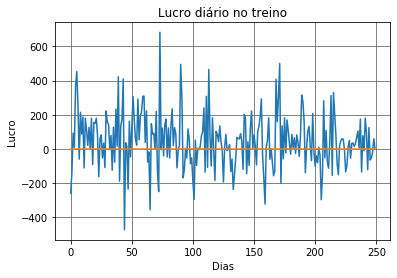

In [64]:

modelo.epsilon = 0
rodar_dias(inputs, custo, 0, dias)
plt.plot(range(0,len(r_dias)), r_dias, range(0,len(r_dias)), np.zeros(len(r_dias)))
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title("Lucro diário no treino", fontdict=None, loc='center', pad=None)
plt.xlabel('Dias')
plt.ylabel('Lucro')
plt.savefig('Treino por dia.pdf')
np.sum(r_dias)

114.50000000000085

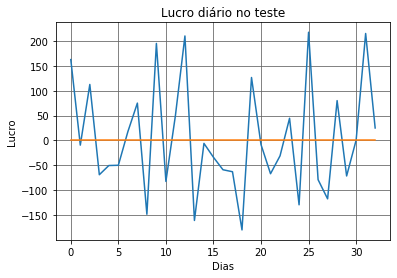

In [69]:
modelo.epsilon = 0
rodar_dias(inputs, custo, dias, 33)
plt.plot(range(0,len(r_dias)), r_dias, range(0,len(r_dias)), np.zeros(len(r_dias)))
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title("Lucro diário no teste", fontdict=None, loc='center', pad=None)
plt.xlabel('Dias')
plt.ylabel('Lucro')
plt.savefig('Teste.pdf')
np.sum(r_dias)

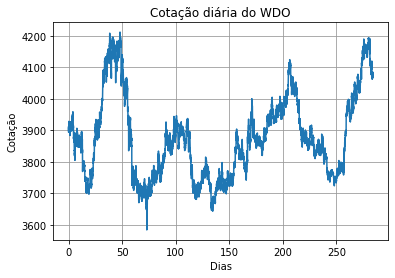

In [42]:
plt.plot(range(0,len(inputs_nao_norm))/batch, inputs_nao_norm['preco'])
plt.grid(b=True, which='major', color='#999999', linestyle='-')
plt.title("Cotação diária do WDO", fontdict=None, loc='center', pad=None)
plt.xlabel('Dias')
plt.ylabel('Cotação')
plt.savefig('cotação WDO.pdf')

In [11]:
np.amin(inputs['preco'])

-275.7738953247049

In [57]:
np.sum(r_dias)

11874.5

In [25]:
len(steps)

284

In [14]:
np.std(inputs_nao_norm['preco'])

130.87810760032863